Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Epoch 1/30
163/163 [==============================] - 498s 3s/step - loss: 0.3374 - accuracy: 0.8921 - val_loss: 57.9753 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - 522s 3s/step - loss: 0.1877 - accuracy: 0.9317 - val_loss: 15.9243 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - 526s 3s/step - loss: 0.1693 - accuracy: 0.9335 - val_loss: 3.6317 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/30
163/163 [==============================] - 527s 3s/step - loss: 0.1569 - accuracy: 0.9421 - val_loss: 40.5476 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/30
163/163 [==============================] - 529s 3s/step - loss: 0.1561 - accuracy: 0.9398 - val_loss: 0.8790 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 6/30
163/163 [==============================] - 532s 3s/step - loss: 0.1469 - accuracy: 0.9471 - val_loss: 8.9252 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/30
163/163 [==============================] - 535s 3s

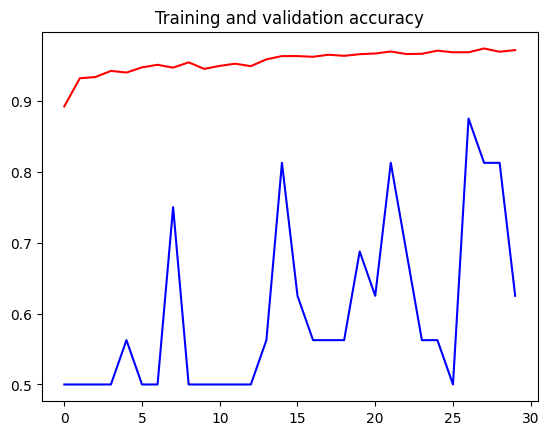

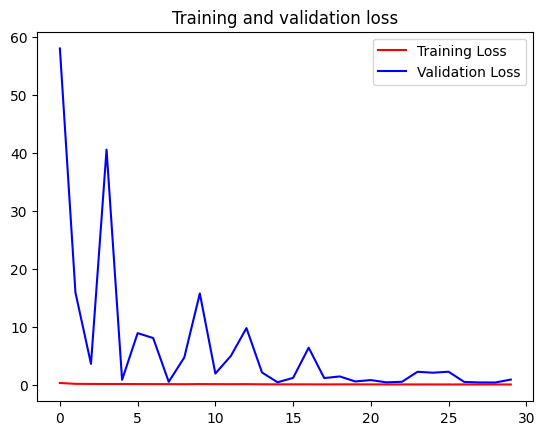

Found 624 images belonging to 2 classes.
20/20 [==============================] - 18s 883ms/step - loss: 0.4700 - accuracy: 0.8429
Test accuracy: 0.8429487347602844


In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Mount Google Drive (assuming the dataset is there)
from google.colab import drive
drive.mount('/content/drive')

# Define paths
zip_file_path = '/content/drive/My Drive/cv_medical_model.zip'
extraction_path = '/content/cv_medical_model'

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Directory setup
base_dir = os.path.join(extraction_path, 'chest_xray')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Image data generators with data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=32, class_mode='binary', target_size=(150, 150))
validation_generator = val_datagen.flow_from_directory(validation_dir, batch_size=32, class_mode='binary', target_size=(150, 150))

# Model building
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5)

# Train the model
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, reduce_lr])

# Plotting training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluate on test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=32, class_mode='binary', target_size=(150, 150))
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test accuracy:', test_accuracy)